In [1]:
import gc

import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import confusion_matrix

from src.utils import calculate_profit, train_val_test_split, signed_log10_1p, ProfitMetric

## Construct the `profit` and `profitable` variables

In [2]:
funnel = pd.read_csv('train_data/funnel.csv')
funnel['profit'] = calculate_profit(funnel)
funnel['log_profit'] = funnel['profit'].apply(signed_log10_1p)
funnel['profitable'] = (funnel['profit'] > 0).astype(int)

## Construct balances

I'll try to get last balance, and then difference from last balance for last few months

In [3]:
balances = pd.read_csv('train_data/balance.csv')

In [4]:
# Sum up across all accounts
account_sums = balances.groupby(['client_id', 'month_end_dt'])[['avg_bal_sum_rur', 'max_bal_sum_rur', 'min_bal_sum_rur']].sum()

# Get average range (max - min) for all clients
account_sums['range'] = account_sums['max_bal_sum_rur'] - account_sums['min_bal_sum_rur']
avg_range = account_sums['range'].mean(level='client_id', skipna=True)

# Get the average amount in the last month
last_month_avg = account_sums.iloc[account_sums.index.get_level_values('month_end_dt') == '2019-08-31']
last_month_avg = last_month_avg['avg_bal_sum_rur']
last_month_avg.index = last_month_avg.index.droplevel('month_end_dt')

# Get differences from the average in the last month
account_sums['diff_last_month'] = account_sums['avg_bal_sum_rur'] - last_month_avg
diffs = account_sums['diff_last_month'].reset_index().query('month_end_dt != "2019-08-31"')
diffs = diffs.pivot(index='client_id', columns='month_end_dt')

# Put together all balance features
diffs.columns = [f'balance_diff_{c[1]}' for c in diffs.columns]
balance_ft = diffs
balance_ft['avg_range'] = avg_range
balance_ft['avg_last_balance'] = last_month_avg

In [5]:
balance_ft.describe()

,balance_diff_2018-09-30,balance_diff_2018-10-31,balance_diff_2018-11-30,balance_diff_2018-12-31,balance_diff_2019-01-31,balance_diff_2019-02-28,balance_diff_2019-03-31,balance_diff_2019-04-30,balance_diff_2019-05-31,balance_diff_2019-06-30,balance_diff_2019-07-31,avg_range,avg_last_balance
count,16455.000000,16710.000000,17056.000000,17412.000000,17633.000000,17942.000000,18271.000000,18423.000000,18582.000000,18605.000000,18618.000000,18619.000000,18619.000000
mean,87.988210,51.673190,46.710483,33.441822,17.955481,10.769981,4.449948,8.166042,5.379130,6.465090,4.418520,52.000720,-90.814759
std,1884.751453,1181.022633,1157.721772,950.131726,553.243603,547.045252,498.944701,476.696726,352.540639,324.753785,262.595122,172.862765,934.295467
min,-38052.000000,-25178.000000,-24428.000000,-23909.000000,-23319.000000,-22554.000000,-21500.000000,-21311.000000,-21300.000000,-21454.000000,-20211.000000,0.000000,-31173.000000
25%,-5.000000,-7.000000,-8.000000,-8.000000,-10.000000,-11.000000,-13.000000,-10.000000,-8.000000,-5.000000,-2.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.833333,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.833333,7.000000
max,108444.000000,77117.000000,77565.000000,76899.000000,11144.000000,13059.000000,12013.000000,22115.000000,11144.000000,11144.000000,5795.000000,7792.083333,38052.000000


## Construct AUM

Same as with balances, but now for assets under managament

In [6]:
aum = pd.read_csv('train_data/aum.csv')

In [7]:
# Sum up across all accounts
aum_sums = aum.groupby(['client_id', 'month_end_dt'])[['balance_rur_amt']].sum()

# Get STD for last few months for client
aum_std = aum_sums.std(level='client_id', skipna=True)

# Get the average amount in the last month
last_month_aum = aum_sums.iloc[aum_sums.index.get_level_values('month_end_dt') == '2019-08-31']
last_month_aum = last_month_aum['balance_rur_amt']
last_month_aum.index = last_month_aum.index.droplevel('month_end_dt')

# Get differences from the average in the last month
aum_sums['diff_last_month'] = aum_sums['balance_rur_amt'] - last_month_aum
diffs = aum_sums['diff_last_month'].reset_index().query('month_end_dt != "2019-08-31"')
diffs = diffs.pivot(index='client_id', columns='month_end_dt')

# Put together all balance features
diffs.columns = [f'aum_diff_{c[1]}' for c in diffs.columns]
aum_ft = diffs
aum_ft['aum_std'] = aum_std
aum_ft['aum_last_month'] = last_month_aum

In [8]:
aum_ft.describe()

,aum_diff_2018-11-30,aum_diff_2018-12-31,aum_diff_2019-01-31,aum_diff_2019-02-28,aum_diff_2019-03-31,aum_diff_2019-04-30,aum_diff_2019-05-31,aum_diff_2019-06-30,aum_diff_2019-07-31,aum_std,aum_last_month
count,8.608000e+03,9.813000e+03,9.955000e+03,1.028500e+04,1.064800e+04,1.092600e+04,1.109900e+04,1.133700e+04,1.145600e+04,1.233600e+04,1.155000e+04
mean,-5.001248e+04,-2.714613e+04,-3.435988e+04,-2.387928e+04,-2.682130e+04,-7.292388e+03,-5.554313e+03,3.399581e+02,3.206510e+03,6.753699e+04,1.689718e+05
std,7.507566e+05,6.796489e+05,6.416814e+05,5.892972e+05,4.643446e+05,3.769064e+05,3.329760e+05,3.086190e+05,2.129571e+05,3.048220e+05,9.854516e+05
min,-4.330515e+07,-4.239884e+07,-3.872596e+07,-2.954090e+07,-2.162469e+07,-2.158606e+07,-2.151494e+07,-2.193740e+07,-7.659409e+06,0.000000e+00,-2.078000e+03
25%,-3.222175e+04,-1.827500e+04,-2.341400e+04,-1.804400e+04,-2.073700e+04,-1.057550e+04,-1.231750e+04,-8.498000e+03,-6.059500e+03,3.975839e+03,4.910000e+02
50%,-6.750000e+02,0.000000e+00,-1.450000e+02,0.000000e+00,-2.040000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.461534e+04,1.172700e+04
75%,7.150000e+03,1.319900e+04,3.943000e+03,7.215000e+03,2.927000e+03,1.339375e+04,8.011000e+03,1.158000e+04,8.908000e+03,4.718967e+04,6.347625e+04
max,7.367170e+06,7.980098e+06,8.014740e+06,1.427104e+07,1.026630e+07,1.093164e+07,7.523952e+06,4.848174e+06,1.108082e+07,1.942198e+07,6.464412e+07


## Construct client dataset

In [9]:
client = pd.read_csv('train_data/client.csv')

In [10]:
# Take out citizenship and job_type, they are useless
client_ft = client.set_index('client_id')[['gender', 'age', 'region', 'city', 'education']]

# Filter out cities and region to only those above 200, make them categorical (not numerical)
region_counts = client_ft['region'].value_counts(dropna=False)
top_regions = region_counts[region_counts > 200].index

city_counts = client_ft['city'].value_counts(dropna=False)
top_cities = city_counts[city_counts > 200].index

client_ft.loc[~ client_ft['city'].isin(top_cities), 'city'] = None
client_ft.loc[~ client_ft['region'].isin(top_regions), 'region'] = None

client_ft['city'] = client_ft['city'].astype('str')
client_ft['region'] = client_ft['region'].astype('str')

client_ft[['gender', 'education']] = client_ft[['gender', 'education']].fillna('nan')

In [11]:
client_ft.describe(include='all')

,gender,age,region,city,education
count,21498,21495.000000,21498,21498,21498
unique,3,NaN,29,17,8
top,F,NaN,nan,nan,nan
freq,11116,NaN,4461,13862,12218
mean,NaN,43.097139,NaN,NaN,NaN
std,NaN,10.798968,NaN,NaN,NaN
min,NaN,21.000000,NaN,NaN,NaN
25%,NaN,34.000000,NaN,NaN,NaN
50%,NaN,42.000000,NaN,NaN,NaN
75%,NaN,52.000000,NaN,NaN,NaN


## Construct transaction features

In [12]:
column_names = ['client_id', 'tran_amt_rur', 'mcc_cd', 'tran_time']
transaction = pd.read_csv('data/trxn.csv', usecols=column_names)


In [13]:
column_names = ['client_id', 'tran_amt_rur', 'mcc_cd', 'tran_time']
transaction = pd.read_csv('data/trxn.csv', usecols=column_names)
transaction_ft = transaction[column_names]
del transaction
gc.collect()
transaction_ft['mcc_cd'] = transaction_ft['mcc_cd'].astype('str')

temp_trs = transaction_ft.groupby(['client_id', 'mcc_cd']).sum().reset_index()
transaction_ft = temp_trs.loc[temp_trs.groupby('client_id').tran_amt_rur.idxmax()]
transaction_ft = transaction_ft.set_index('client_id')
transaction_ft['tran_amt_rur'] = transaction_ft['tran_amt_rur'].fillna('nan')
del temp_trs
gc.collect()

0

## Construct payment features

In [14]:
payments = pd.read_csv('data/payments.csv')

# Get pensioneers
pensioneers = payments.query('pmnts_name == "Pension receipts"').client_id.unique()
pensioneers = pd.DataFrame({'is_pensioneer': 1}, index=pensioneers)

# Get date to first of month for grouping
payments['month'] = pd.to_datetime(payments['day_dt']).apply(lambda x: x + MonthEnd(1))
payments_months = payments.groupby(['client_id', 'month']).sum('sum_rur').reset_index()
del payments

payments_months = payments_months.pivot(index='client_id', columns='month')
payments_months.columns = [f'payments_{c[1].strftime("%Y_%m_%d")}' for c in payments_months.columns]
payments_months['payments_mean'] = payments_months.mean(axis=1)
payments_months['payments_std'] = payments_months.std(axis=1)

payments_ft = pd.concat([
    payments_months,
    pensioneers
], axis=1).fillna({'is_pensioneer': 0})
del payments_months, pensioneers

In [15]:
payments_ft.describe()

,payments_2018_09_30,payments_2018_10_31,payments_2018_11_30,payments_2018_12_31,payments_2019_01_31,payments_2019_02_28,payments_2019_03_31,payments_2019_04_30,payments_2019_05_31,payments_2019_06_30,payments_2019_07_31,payments_2019_08_31,payments_2019_09_30,payments_mean,payments_std,is_pensioneer
count,6.174000e+03,6.546000e+03,6.769000e+03,7.215000e+03,6.946000e+03,7.349000e+03,7.639000e+03,7.606000e+03,7.739000e+03,7.880000e+03,7.937000e+03,7.670000e+03,1.489000e+03,8.954000e+03,8.954000e+03,8954.000000
mean,4.649791e+04,5.921758e+04,6.251023e+04,8.181019e+04,4.553332e+04,5.879817e+04,8.534493e+04,6.186301e+04,7.413143e+04,6.294312e+04,6.918894e+04,5.530271e+04,3.554693e+04,5.884695e+04,3.729472e+04,0.134242
std,5.488404e+04,6.870386e+04,8.516996e+04,1.108685e+05,9.824093e+04,1.034744e+05,4.618311e+05,3.899286e+05,1.458242e+05,8.736189e+04,1.033125e+05,9.686230e+04,6.633839e+04,9.290501e+04,1.545691e+05,0.340931
min,0.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01,4.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000
25%,1.649925e+04,2.211375e+04,2.228500e+04,2.708400e+04,1.214100e+04,2.205400e+04,2.552650e+04,2.058225e+04,2.041600e+04,1.926175e+04,2.043600e+04,1.460900e+04,9.751000e+03,2.313831e+04,8.937610e+03,0.000000
50%,3.142550e+04,4.205850e+04,4.222000e+04,5.480700e+04,2.485300e+04,3.976000e+04,4.635100e+04,3.805950e+04,4.065800e+04,3.820300e+04,4.089800e+04,3.118250e+04,1.586400e+04,4.227073e+04,2.092185e+04,0.000000
75%,5.767775e+04,7.284075e+04,7.274200e+04,1.018275e+05,5.258175e+04,6.924200e+04,8.403600e+04,7.003800e+04,8.033550e+04,7.460900e+04,8.186100e+04,6.265050e+04,3.437600e+04,7.113442e+04,4.258665e+04,0.000000
max,1.017439e+06,1.723394e+06,1.710482e+06,3.473752e+06,6.313440e+06,6.665536e+06,3.121338e+07,3.238552e+07,7.284738e+06,2.282551e+06,4.200866e+06,4.173208e+06,1.186703e+06,3.563451e+06,8.871723e+06,1.000000


## Construct mystery features

In [16]:
mystery_feats = pd.read_csv('train_data/funnel.csv', usecols=['client_id'] + [f'feature_{i}' for i in range(1, 11)])
mystery_feats = mystery_feats.set_index('client_id')
mystery_feats['feature_1'] = mystery_feats['feature_1'].astype(str)

## Construct final dataset

In [17]:
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable', 'log_profit']
CAT_FEATURES = ['gender', 'region', 'city', 'education', 'mcc_cd', 'feature_1']
LABEL = 'log_profit'

labels_all = funnel.set_index('client_id')[LABEL_COLS]
full_data = pd.concat([
    labels_all,
    balance_ft,
    aum_ft,
    client_ft,
    transaction_ft,
    payments_ft,
    mystery_feats
], axis=1)
full_data = full_data.fillna({'mcc_cd': 'nan'})

## Split into train, val, test

In [18]:
train, val, test = train_val_test_split(full_data, [0.8, 0.1, 0.1])

train_pool = Pool(
    data = train.drop(LABEL_COLS, axis=1),
    label = train[LABEL],
    cat_features=CAT_FEATURES
)

val_pool = Pool(
    data = val.drop(LABEL_COLS, axis=1), 
    label = val[LABEL],
    cat_features=CAT_FEATURES
)
test_pool = Pool(data = test.drop(LABEL_COLS, axis=1), cat_features=CAT_FEATURES)

print(val.profit.mean())
print(test.profit.mean())
print(train.profit.mean())

3043.2036976744193
2805.0767441860467
2501.6929265030817


## Construct model

In [19]:
model = CatBoostRegressor(
    iterations=1500,
    depth=10,
#     l2
    loss_function='RMSE',
#     eval_metric=ProfitMetric,
    use_best_model=True,
)

## Run training

In [20]:
model.fit(train_pool, eval_set=val_pool, verbose=100)

Learning rate set to 0.061276
0:	learn: 2.8609506	test: 2.9133520	best: 2.9133520 (0)	total: 121ms	remaining: 3m 1s
100:	learn: 1.9872869	test: 2.3022589	best: 2.3014809 (91)	total: 6.67s	remaining: 1m 32s
200:	learn: 1.7458944	test: 2.2868795	best: 2.2868795 (200)	total: 13.9s	remaining: 1m 29s
300:	learn: 1.5424620	test: 2.2876170	best: 2.2868795 (200)	total: 20.9s	remaining: 1m 23s
400:	learn: 1.3737941	test: 2.2841334	best: 2.2830042 (367)	total: 28.2s	remaining: 1m 17s
500:	learn: 1.2456372	test: 2.2851736	best: 2.2810839 (437)	total: 35.7s	remaining: 1m 11s
600:	learn: 1.1284809	test: 2.2831040	best: 2.2810839 (437)	total: 43s	remaining: 1m 4s
700:	learn: 1.0253907	test: 2.2826571	best: 2.2810839 (437)	total: 50.3s	remaining: 57.4s
800:	learn: 0.9476549	test: 2.2824972	best: 2.2810839 (437)	total: 58.2s	remaining: 50.8s
900:	learn: 0.8751429	test: 2.2851787	best: 2.2810839 (437)	total: 1m 5s	remaining: 43.6s
1000:	learn: 0.8085898	test: 2.2860127	best: 2.2810839 (437)	total: 1m 1

## Evaluate profitability of solution on val

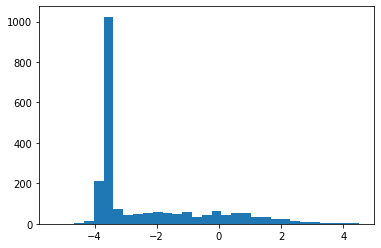

In [21]:
import matplotlib.pyplot as plt
plt.hist(model.predict(val_pool), bins=31);

In [22]:
for threshold in np.arange(-3, -1, 0.1):
    pred_val = model.predict(val_pool) > threshold
    bs_prof_val = val['profit'].mean()

    model_prof_val = calculate_profit(val)[pred_val.astype(bool)].sum()
    model_prof_val = model_prof_val / len(pred_val)

    print(f'VAL {threshold} | Baseline profit: {bs_prof_val:.2f}, model profit: {model_prof_val:.2f}')

VAL -3.0 | Baseline profit: 3043.20, model profit: 5918.69
VAL -2.9 | Baseline profit: 3043.20, model profit: 5910.01
VAL -2.8 | Baseline profit: 3043.20, model profit: 5867.47
VAL -2.6999999999999997 | Baseline profit: 3043.20, model profit: 5845.02
VAL -2.5999999999999996 | Baseline profit: 3043.20, model profit: 5863.29
VAL -2.4999999999999996 | Baseline profit: 3043.20, model profit: 5906.48
VAL -2.3999999999999995 | Baseline profit: 3043.20, model profit: 5932.45
VAL -2.2999999999999994 | Baseline profit: 3043.20, model profit: 5947.50
VAL -2.1999999999999993 | Baseline profit: 3043.20, model profit: 5961.78
VAL -2.099999999999999 | Baseline profit: 3043.20, model profit: 5934.54
VAL -1.9999999999999991 | Baseline profit: 3043.20, model profit: 5933.78
VAL -1.899999999999999 | Baseline profit: 3043.20, model profit: 5948.71
VAL -1.799999999999999 | Baseline profit: 3043.20, model profit: 5962.03
VAL -1.6999999999999988 | Baseline profit: 3043.20, model profit: 5927.83
VAL -1.59999

In [47]:
threshold = -2.3

## Evaluate profitability of solution on test

In [48]:
pred_test = model.predict(test_pool) > threshold
bs_prof_test = test['profit'].mean()

model_prof_test = calculate_profit(test)[pred_test.astype(bool)].sum()
model_prof_test = model_prof_test / len(pred_test)

print(f'TEST | Baseline profit: {bs_prof_test:.2f}, model profit: {model_prof_test:.2f}')

TEST | Baseline profit: 2805.08, model profit: 5614.02


## Notes

1. Using just balance  or features, I get below baseline
2. Using balance + client features, I get 3074 on test,  3345.24 on val
3. Using balance + aum + client fts, I get 2944.95 on test, 3607.06 on val
4. Same as prev step - but using regressor, I get crazy 5289 on test, 5792 on val
5. Same step as prev, but using signed log on profit + thresholding I get 5906.70 on val, and 5516.17 on test
6. Same as prev + transaction features, I get 5887.00 on val, and 5442.85 ont test
7. above + payment fts, I get 5959.00 on val, 5458.27 on test
8. above + mystery fts, I get 5961.78 on val, and 5597.67 on test

## Grid search for best params

In [41]:
# full_data_train= full_data.drop(LABEL_COLS, axis=1)
# full_data_pool = Pool(
#     data = full_data_train, 
#     label = full_data['log_profit'],              
#     cat_features=CAT_FEATURES
# )

# model = CatBoostRegressor(
#     iterations=1500,
#     depth=10,
#     loss_function='RMSE',
#     verbose=100,
# )

# gs_res = model.grid_search(
#     X=full_data_pool,
#     search_by_train_test_split=True,
#     train_size=0.8,
#     partition_random_seed=42,
#     param_grid={'depth': [8,10], 'l2_leaf_reg': [1, 3, 6], 'bagging_temperature': [0, 1, 2]},
#     verbose=True,
# )

## Feature importance

In [42]:
model.get_feature_importance(val_pool, 
    type='FeatureImportance', prettified=True
)

,Feature Id,Importances
0,education,21.339537
1,feature_1,4.549388
2,avg_last_balance,3.979205
3,feature_4,3.949084
4,feature_6,3.320294
5,region,2.984973
6,feature_9,2.870662
7,age,2.248463
8,tran_amt_rur,2.175722
9,aum_diff_2018-11-30,2.002453


## Save model on FULL data and save it

In [43]:
model.save_model('models/tadej_model.cbm', 'cbm')

## Test load, data and produce predictions

In [44]:
# Save data first, as it would be in the build step
full_data.drop(LABEL_COLS, axis=1).to_pickle('final_version.pickle')

In [45]:
model = CatBoostRegressor().load_model('models/tadej_model.cbm', 'cbm')
data = pd.read_pickle('final_version.pickle')
data_pool = Pool(data = data, cat_features=CAT_FEATURES)

target = (model.predict(data_pool) > threshold).astype(int)
submission = pd.DataFrame({'client_id': data.index, 'target': target})
submission.to_csv('submission.csv', index=False)

In [46]:
pd.read_csv('submission.csv')

,client_id,target
0,-9221941791080978530,0
1,-9220369594510368140,0
2,-9220236243053692422,1
3,-9220233431709087652,0
4,-9219699286371310531,0
...,...,...
21493,9219024469308275500,0
21494,9219416956046769492,0
21495,9219968212912398941,0
21496,9220335314469087849,0
